# Notebook para analisar os resultados

In [1]:
import os

root_dir = "/home/lorenzo-varaschin/solar_forecasting/mestrado/projeto_visao_comp/model_checkpoints"
model_checkpoints = {ckpt_name.replace(".ckpt", ""): os.path.join(root_dir, ckpt_name) for ckpt_name in sorted(os.listdir(root_dir)) if ckpt_name.startswith("_")}
model_checkpoints

{'_1__encoder_only__linear__space_time': '/home/lorenzo-varaschin/solar_forecasting/mestrado/projeto_visao_comp/model_checkpoints/_1__encoder_only__linear__space_time.ckpt',
 '_2__encoder_only__linear__quad_TSST': '/home/lorenzo-varaschin/solar_forecasting/mestrado/projeto_visao_comp/model_checkpoints/_2__encoder_only__linear__quad_TSST.ckpt',
 '_3__encoder_only__unet__space_time': '/home/lorenzo-varaschin/solar_forecasting/mestrado/projeto_visao_comp/model_checkpoints/_3__encoder_only__unet__space_time.ckpt',
 '_4_encoder_only_unet_quad_TSST': '/home/lorenzo-varaschin/solar_forecasting/mestrado/projeto_visao_comp/model_checkpoints/_4_encoder_only_unet_quad_TSST.ckpt',
 '_5__decoder_only__linear__space_time': '/home/lorenzo-varaschin/solar_forecasting/mestrado/projeto_visao_comp/model_checkpoints/_5__decoder_only__linear__space_time.ckpt',
 '_6__decoder_only__linear__quad_TSST': '/home/lorenzo-varaschin/solar_forecasting/mestrado/projeto_visao_comp/model_checkpoints/_6__decoder_only__l

In [2]:
from predformer import PredFormer
from data import make_dataloaders

device = 0 # cpu ou número da GPU

# carregar os modelos e seus checkpoints
models = dict()
for model_name, model_ckpt in model_checkpoints.items():
    models[model_name] = PredFormer.load_from_checkpoint(
        model_ckpt,
        map_location=f"cuda:{device}" if isinstance(device, int) else device
    ).eval()
train_dataloader, val_dataloader, test_dataloader = make_dataloaders(batch_size=16)

/home/lorenzo-varaschin/miniconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.2, which is newer than your current Lightning version: v2.5.0.post0


In [5]:
from tqdm import tqdm
import numpy as np
def get_model_preds(models, dataloader):
    # ground truth ghi
    ghi_trues = np.stack(dataloader.dataset.tgt_ghi)
    
    # para calcular a previsão do modelo persistente basta pegar o kt atual e mutliplicar pela GHI de céu claro futura
    current_kt = np.stack(dataloader.dataset.src_kt_solis)[:, -1] # -1 corresponde ao timestep "t"
    future_ghi_solis = np.stack(dataloader.dataset.tgt_ghi_solis) 
    persistence_preds = current_kt[:, None] * future_ghi_solis

    model_preds = {
        "ghi_trues": ghi_trues,
        "persistence": persistence_preds
    }
    for model_name, model in models.items():
        print(f"*********Obtendo as previsões do modelo {model_name}*********")
        ghi_preds = np.zeros_like(ghi_trues)
        B = dataloader.batch_size
        for batch_idx, batch in enumerate(tqdm(dataloader)):
            outs_ = model.sample(batch, batch_idx)
            ghi_preds[B*batch_idx: B*(batch_idx+1)] = outs_["ghi_preds"]

            #framewise ssim
            for t, ssim_ in enumerate(model.test_metrics_img):
                model.test_metrics_img[ssim_].update(outs_["preds"][:, t], outs_["trues"][:, t])

            #framewise ghi
            for t, rmse_ in enumerate(model.test_metrics_ghi):
                model.test_metrics_ghi[rmse_].update(outs_["ghi_preds"][:, t], outs_["tgt_ghi"][:, t])
        
        model_preds[model_name] = ghi_preds
    return model_preds

In [19]:
model_preds_backup = model_preds

In [13]:
model_preds = get_model_preds(models, test_dataloader)

In [21]:
model_preds["persistence"]

array([[ 16.69370846,  17.05460602,  17.41259129,  17.76756584,
         18.11943471],
       [ 17.05081738,  17.40872314,  17.76361883,  18.11540952,
         18.46400312],
       [ 19.10273288,  19.4921628 ,  19.87818558,  20.26070016,
         20.63960858],
       ...,
       [173.21176038, 169.66334869, 166.08573736, 162.47993498,
        158.84698094],
       [169.29920419, 165.7292714 , 162.13120807, 158.50605136,
        154.85487587],
       [165.73983956, 162.14154679, 158.51615891, 154.8647506 ,
        151.18843489]])

### **Análise da GHI**

In [67]:
import pandas as pd
from sklearn.metrics import root_mean_squared_error

# tabelar os resultados de RMSE e FS
# calcular o desempenho do modelo persistence
df_results_ghi = {}
for t, (preds_, trues_) in enumerate(zip(model_preds["persistence"].T, model_preds["ghi_trues"].T)):
    df_results_ghi[(f"RMSE [W/m2]", f"t+{2*(t+1)}")] = root_mean_squared_error(preds_, trues_)
for t in range(model_preds["persistence"].shape[1]):
    rmse_pers = df_results_ghi[(f"RMSE [W/m2]", f"t+{2*(t+1)}")]
    df_results_ghi[(f"FS [%]", f"t+{2*(t+1)}")] = 100*(1 - rmse_pers / rmse_pers)
df_results_ghi = pd.DataFrame(df_results_ghi, index=["persistence"])

for name_, model_ in models.items():
    rmse_model = model_.test_metrics_ghi.compute()
    for t, rmse_ in enumerate(rmse_model.values()):
        rmse_pers = df_results_ghi.loc["persistence", (f"RMSE [W/m2]", f"t+{2*(t+1)}")]
        df_results_ghi.loc[name_, (f"RMSE [W/m2]", f"t+{2*(t+1)}")] = rmse_.item()
        df_results_ghi.loc[name_, (f"FS [%]", f"t+{2*(t+1)}")] = 100*(1 - rmse_.item() / rmse_pers)

In [69]:
df_results_ghi

RMSE [W/m2]                          \
                                             t+2         t+4         t+6   
persistence                            93.613627  117.378045  129.833574   
_1__encoder_only__linear__space_time   90.111542   94.133530   99.248009   
_2__encoder_only__linear__quad_TSST    86.675697   92.705986   98.219742   
_3__encoder_only__unet__space_time     97.570496  101.307449  104.641937   
_4_encoder_only_unet_quad_TSST         95.424355  100.270599  104.116875   
_5__decoder_only__linear__space_time   82.609863   92.325104   99.191200   
_6__decoder_only__linear__quad_TSST    87.863678   96.847389  102.412796   
_7__decoder_only__unet__space_time     79.622299   94.014862  102.494461   
_8__decoder_only__unet__quad_TSST      80.710457   95.446365  104.259804   

                                                                 FS [%]  \
                                             t+8        t+10        t+2   
persistence                           137.629415  143.096495   0.000000   
_1__encoder_only__linear__space_time  103.948975  107.507378   3.740999   
_2__encoder_only__linear__quad_TSST   102.203880  105.797264   7.411239   
_3__encoder_only__unet__space_time    107.729736  110.726486  -4.226809   
_4_encoder_only_unet_quad_TSST        106.998222  109.886208  -1.934257   
_5__decoder_only__linear__space_time  105.157249  109.823517  11.754446   
_6__decoder_only__linear__quad_TSST   106.992096  110.888931   6.142213   
_7__decoder_only__unet__space_time    108.681770  113.469818  14.945824   
_8__decoder_only__unet__quad_TSST     110.269829  115.083206  13.783431   

                                                                       \
                                            t+4        t+6        t+8   
persistence                            0.000000   0.000000   0.000000   
_1__encoder_only__linear__space_time  19.803120  23.557516  24.471833   
_2__encoder_only__linear__quad_TSST   21.019313  24.349505  25.739799   
_3__encoder_only__unet__space_time    13.691313  19.403022  21.724774   
_4_encoder_only_unet_quad_TSST        14.574656  19.807434  22.256284   
_5__decoder_only__linear__space_time  21.343805  23.601271  23.593914   
_6__decoder_only__linear__quad_TSST   17.491053  21.119944  22.260735   
_7__decoder_only__unet__space_time    19.904219  21.057044  21.033036   
_8__decoder_only__unet__quad_TSST     18.684653  19.697348  19.879171   

                                                 
                                           t+10  
persistence                            0.000000  
_1__encoder_only__linear__space_time  24.870712  
_2__encoder_only__linear__quad_TSST   26.065789  
_3__encoder_only__unet__space_time    22.621105  
_4_encoder_only_unet_quad_TSST        23.208316  
_5__decoder_only__linear__space_time  23.252127  
_6__decoder_only__linear__quad_TSST   22.507584  
_7__decoder_only__unet__space_time    20.703985  
_8__decoder_only__unet__quad_TSST     19.576502

In [76]:
# SALVAR OS RESULTADOS TABELADOS PARA COLOCAR NO RELATÓRIO

# rmse_res = df_results_ghi["RMSE [W/m2]"]
# rmse_res.index = [f"Modelo {i}" if i != 0 else "Persistence" for i, name_ in enumerate(rmse_res.index)]
# rmse_res.to_latex(
#     "ghi_rmse.tex",
#     caption="Tabela com o RMSE da GHI (em W/m2) de cada modelo.",
#     label="tab:rmse_ghi",
#     float_format="%.2f",
# )

# fs_res = df_results_ghi["FS [%]"]
# fs_res.index = [f"Modelo {i}" if i != 0 else "Persistence" for i, name_ in enumerate(rmse_res.index)]
# fs_res.to_latex(
#     "ghi_fs.tex",
#     caption="Tabela com o FS da GHI (em %) de cada modelo.",
#     label="tab:fs_ghi",
#     float_format="%.2f"
# )

In [78]:
# dicionario para plotar gráfico do forecasting skill
fs_plot_results = {
    "U-Net": {
        "Espaço-Temporal":{
            "Encoder Only": df_results_ghi.loc["_3__encoder_only__unet__space_time", "FS [%]"].tolist(),
            "Decoder Only": df_results_ghi.loc["_7__decoder_only__unet__space_time", "FS [%]"].tolist(),
                
        },
        "Espacial+Temporal":{
            "Encoder Only": df_results_ghi.loc["_4_encoder_only_unet_quad_TSST", "FS [%]"].tolist(),
            "Decoder Only": df_results_ghi.loc["_8__decoder_only__unet__quad_TSST", "FS [%]"].tolist(),
        }
    },
    "Linear": {
        "Espaço-Temporal":{
            "Encoder Only": df_results_ghi.loc["_1__encoder_only__linear__space_time", "FS [%]"].tolist(),
            "Decoder Only": df_results_ghi.loc["_5__decoder_only__linear__space_time", "FS [%]"].tolist(),
        },
        "Espacial+Temporal":{
            "Encoder Only": df_results_ghi.loc["_2__encoder_only__linear__quad_TSST", "FS [%]"].tolist(),
            "Decoder Only": df_results_ghi.loc["_6__decoder_only__linear__quad_TSST", "FS [%]"].tolist(),
        }
    }
}

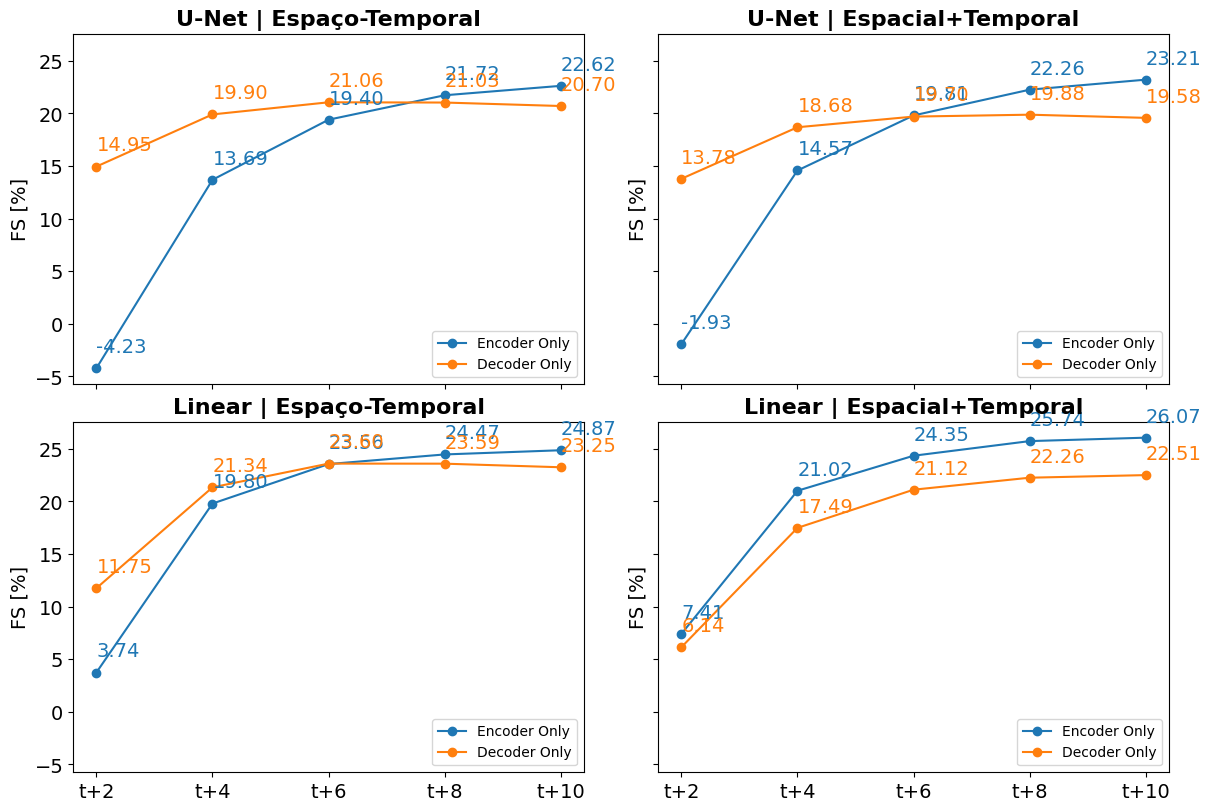

In [127]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots (2, 2, figsize=(12, 8), sharex=True, sharey=True, layout="constrained")
for i, (autoenc_type, autoenc_res) in enumerate(fs_plot_results.items()):
    for j, (attn_type, attn_res) in enumerate(autoenc_res.items()):
        axes[i, j].plot([f"t+{2*(i+1)}" for i in range(5)], attn_res["Encoder Only"], label="Encoder Only", marker="o")
        axes[i, j].plot([f"t+{2*(i+1)}" for i in range(5)], attn_res["Decoder Only"], label="Decoder Only", marker="o")

        for t in range(5):
            axes[i, j].text(f"t+{2*(t+1)}", attn_res["Encoder Only"][t]+1.5, f"{attn_res["Encoder Only"][t]:.2f}", color="C0", fontsize=14)
            axes[i, j].text(f"t+{2*(t+1)}", attn_res["Decoder Only"][t]+1.5, f"{attn_res["Decoder Only"][t]:.2f}", color="C1", fontsize=14)

        
        axes[i, j].legend(loc="lower right")
        axes[i, j].set_ylabel("FS [%]", fontsize=14)
        axes[i, j].tick_params(axis="both", labelsize=14)
        axes[i, j].set_title(f"{autoenc_type} | {attn_type}", fontsize=16, weight="bold")

#plt.savefig("forecastin_skill_results", dpi=200, bbox_inches="tight")

- Com exceção do caso Linear | Espacial+Temporal, o modelo decoder only apresentou um desempenho melhor no começo mas pior no final. Isso é esperado, uma vez que esse modelo faz a previsão de forma autoregressiva e o erro começa a acumlar rapidamente.
- Comparando os dois tipos de atenção, o impacto foi pequeno, principalmente nos horizontes mais distantes (t+8 e t+10), e parece estar tudo dentro de um desvio padrão. No entanto, a atenção do tipo Espacial+Temporal é, computacionalmente, muito mais leve do que a Espaço-Temporal. Logo é possível ganhar em desempenho computacional sem perder nada no desempenho da previsão.
- Comparando os dois tipos de autoencoder, a U-Net parece ter tido um desempenho pior. Isso parece ser estranho, pois o contrário era esperado. Portanto, esse fenômeno será investigado em mais detalhes abaixo.

### **Comparando U-Net com Linear**

Para essa análise, algumas previsões dos modelos `_2__encoder_only__linear__quad_TSST` e `_4_encoder_only_unet_quad_TSST` serão comparados entre si.

In [143]:
from torch.utils.data import default_collate

def get_batch(dataset, idxs_):
    """
    Função para criar um batch do dataset a partir dos idxs_ para poder utilizar o model.sample
    """
    samples = [dataset[i] for i in idxs_]
    batch = default_collate(samples)
    return batch

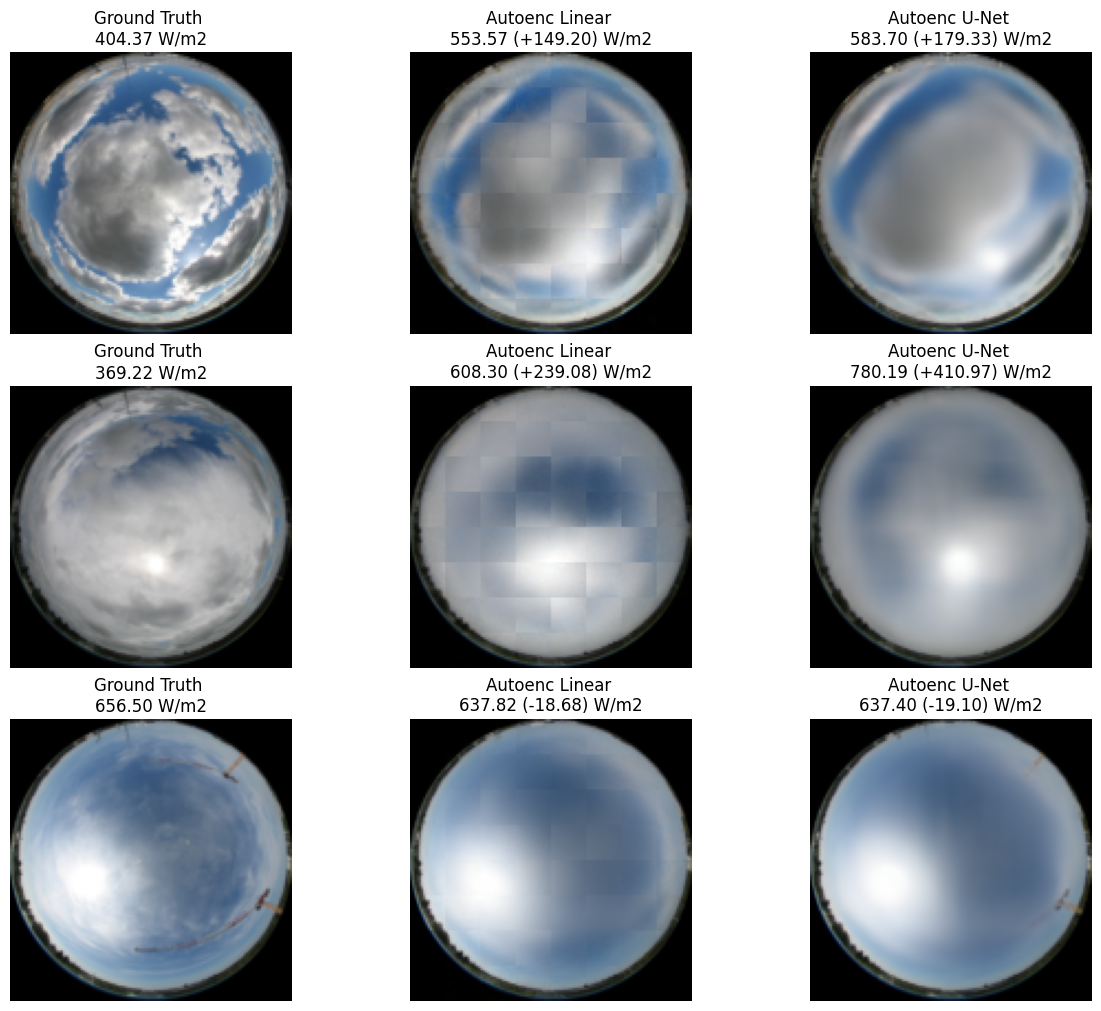

In [199]:
idxs_ = [8000, 22000, 30000]
fig, axes = plt.subplots(len(idxs_), 3, figsize=(12, 10), layout="constrained")
batch = get_batch(test_dataloader.dataset, idxs_)
outs_linear = models["_2__encoder_only__linear__quad_TSST"].sample(batch, 0)
outs_unet = models["_4_encoder_only_unet_quad_TSST"].sample(batch, 0)
for ax in axes.ravel():
    ax.set_axis_off()
for i, (img_true, img_pred_linear, img_pred_unet) in enumerate(zip(outs_linear["trues"], outs_linear["preds"], outs_unet["preds"])):
    ghi_trues_ = outs_linear['tgt_ghi'][i, -1]
    ghi_preds_linear = outs_linear['ghi_preds'][i, -1]
    ghi_preds_unet = outs_unet['ghi_preds'][i, -1]
    
    axes[i, 0].imshow(np.clip(img_true[-1].permute(1, 2, 0), 0, 1))
    axes[i, 0].set_title(f"Ground Truth \n{ghi_trues_:.2f} W/m2")
    
    axes[i, 1].imshow(np.clip(img_pred_linear[-1].permute(1, 2, 0), 0, 1))
    axes[i, 1].set_title(f"Autoenc Linear \n{ghi_preds_linear:.2f} ({'+' if ghi_preds_linear-ghi_trues_ > 0 else ''}{ghi_preds_linear-ghi_trues_:.2f}) W/m2")

    axes[i, 2].imshow(np.clip(img_pred_unet[-1].permute(1, 2, 0), 0, 1))
    axes[i, 2].set_title(f"Autoenc U-Net \n{ghi_preds_unet:.2f} ({'+' if ghi_preds_unet-ghi_trues_ > 0 else ''}{ghi_preds_unet-ghi_trues_:.2f}) W/m2")
plt.savefig("predicted_images", dpi=200, bbox_inches="tight")

- Embora as previsões de GHI do modelo com autoencoder linear estejam melhores, percebe-se fortes artefatos nas imagens geradas nas bordas dos patches. Portanto, usar exclusivamente métricas da GHI para avaliar os modelos pode não ser o mais adequado. Além disso, manter a ResNet50 que estima o kt congelada também pode ser um problema;
- Além disso, percebe-se que o guindaste presente na última imagem desaparaceu da previsão com autoencoder linear. Isso é no mínimo estranho para um modelo cujo objetivo deveria ser prever o futuro, já que esse guindaste permanece imóvel na sequência de entrada.